In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import time
import math
import random
import lib

In [2]:
X_val, y_val, X_test, y_test = lib.load_dataset("../dataset_clusterified", rgb=False)

In [3]:
X_val_bgr = X_val

In [4]:
def show_image(img, to_rgb=True):
    if to_rgb:
        rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        rgb = img
    plt.imshow(rgb,interpolation='nearest')
    plt.show()

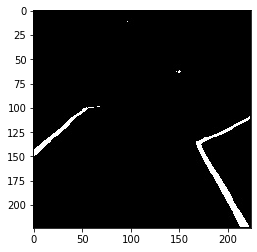

In [5]:
show_image(X_val_bgr[200])

In [6]:
class Config:
    def __init__(self, *args, **kwargs):
        self._d = kwargs
    def __getattr__(self, name):
        return self._d[name]

In [7]:
config = Config(
    gaussian_blur_kernel_size=(7, 7),
    gaussian_blur_sigma_x=1,
    top_offset_pct=0.25,
    canny_threshold1=190,
    canny_threshold2=250,
    houghlines_threshold=50,
)

In [8]:
def get_line_color_code(theta):
    b, g, r = 0, 0, 0
    # towards left: red
    if theta > np.pi/2:
        r = 255
    # towards right: blue
    else:
        b = 255
    return b, g, r

In [9]:
from math import isclose

def preprocess(img, show=False):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if show:
        show_image(gray)
        
    blur = cv2.GaussianBlur(gray, config.gaussian_blur_kernel_size, config.gaussian_blur_sigma_x)
    if show:
        show_image(blur)

    height, width = blur.shape
    offset = int(height * config.top_offset_pct)
    blur_bottom = blur[offset:height,:]
    if show:
        show_image(blur_bottom)
    
    edges = cv2.Canny(blur_bottom, config.canny_threshold1, config.canny_threshold2)
    if show:
        show_image(edges)
    
    return edges

def get_lines(img, preprocess=preprocess, show=False):
    if show:
        show_image(img)
        
    offset = int(img.shape[0] * config.top_offset_pct)
    edges = preprocess(img, show=show)
   
    lines = lib.detect_lines_parametric(edges, config.houghlines_threshold)
    
    img_lines = lib.draw_lines_parametric(img, lines, offset=offset, color_func=get_line_color_code)
    
    if show:
        show_image(img_lines)
            
    return lines, img_lines

In [10]:
begin = time.time()
get_lines(X_val_bgr[200])
end = time.time()
print(f"get_lines took {end-begin:.3}s")

get_lines took 0.0716s


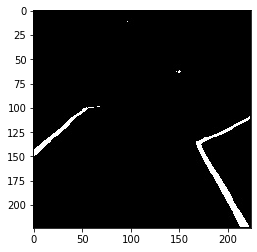

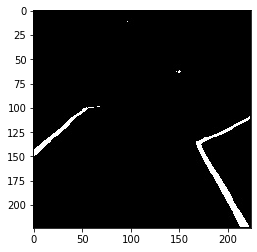

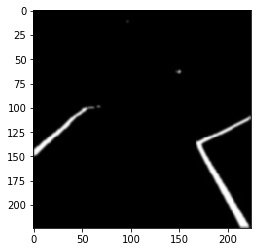

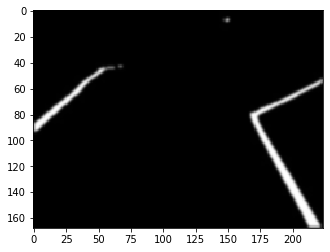

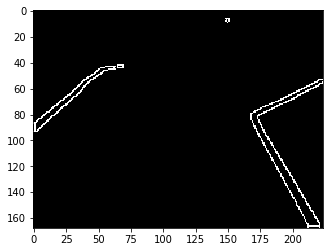

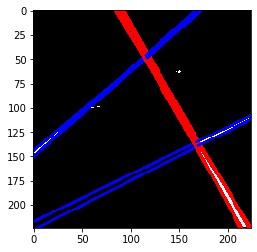

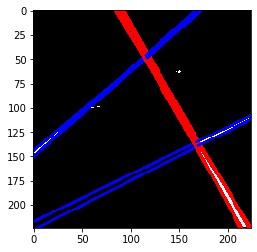

In [11]:
show_image(get_lines(X_val_bgr[200], show=True)[1])

In [12]:
img_set = [X_val_bgr[i] for i in range(0, 4000, 150)]

In [13]:
img_lines_set = [get_lines(img)[1] for img in img_set]

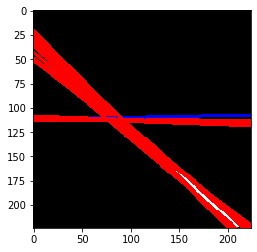

In [16]:
lines, img_lines = get_lines(X_val_bgr[1350])
show_image(img_lines)

In [17]:
def get_direction(lines):
    if lines is None:
        return 0
    left = []
    right = []
    for line in lines:
        for rho, theta in line:
            # the higher the value, the more we should turn
            if theta > np.pi/2:
                left.append(np.pi - theta)
            else:
                right.append(theta)
    # get direction (keep intensity from main direction)
    if not left and not right:
        return 0
    elif not left:
        return math.sin(np.mean(right))#/(np.pi/2)
    elif not right:
        return math.sin(-np.mean(left))#/(np.pi/2)
    else:
        return 0

In [18]:
def stick_to_labels(get_direction):
    def f(lines):
        if get_direction(lines) < -0.75:
            return -1
        elif get_direction(lines) < -0.25:
            return -0.5
        elif get_direction(lines) < 0.25:
            return 0
        elif get_direction(lines) < 0.75:
            return 0.5
        return 1
    return f

In [19]:
get_direction(lines)

0

In [20]:
class ClassicHoughlinesEstimator(lib.Estimator):
    def __init__(self, get_lines, get_direction):
        self.get_lines = get_lines
        self.get_direction = get_direction
    
    def predict_one(self, img):
        return self.get_direction(self.get_lines(img)[0])

In [21]:
ClassicHoughlinesEstimator(get_lines, get_direction).score(X_val, y_val)

(0.23301202419410505, 0.36380373055707516)

In [22]:
ClassicHoughlinesEstimator(get_lines, get_direction).score(X_test, y_test)

(0.23412352935390246, 0.36754898145555553)

In [23]:
ClassicHoughlinesEstimator(get_lines, stick_to_labels(get_direction)).score(X_val, y_val)

(0.2126943117672601, 0.3252496743378202)